# Artificial neural network

In [1]:
#imports
from preprocessing.preprocessing import get_preprocessed_brfss_dataset
from preprocessing.neural_network_preprocessing import get_number_of_numerical_features, NeuralNetworkPreprocessor, CATEGORICAL_COLUMNS, NUMERICAL_COLUMNS
from visualization.general_plots import plot_class_frequencies
from visualization.neural_network_plots import plot_loss, plot_accuracy

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils

import numpy as np

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
use_mps = True
use_cuda = False

device = torch.device("cpu")

if torch.has_mps and use_mps:
    device = torch.device("mps")
    print("Torch mps activated")

if torch.has_cuda and use_cuda:
    device = torch.device("cuda")
    print("Torch cuda activated")

Torch mps activated


Looking at the dataset it becomes clear that it is imbalanced

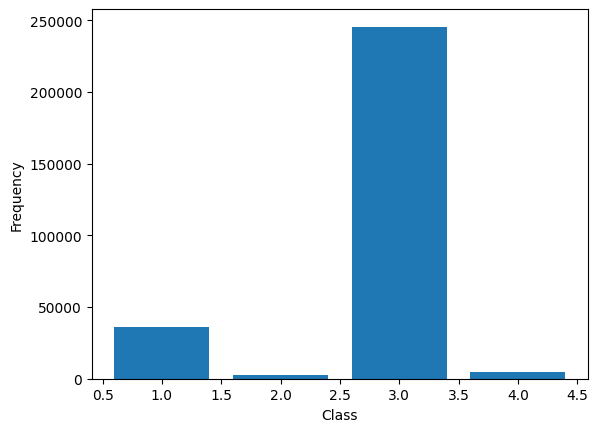

In [4]:
train_dataset, target = get_preprocessed_brfss_dataset()
plot_class_frequencies(target)

In [5]:
preprocessor = NeuralNetworkPreprocessor()
data_train, data_test, target_train, target_test = preprocessor.get_preprocessed_dataset_for_neural_network()
target_train.head(10)

,Yes,"Yes, but only during pregnancy",No,"No, but pre-diabetes"
91668,0.0,0.0,1.0,0.0
111052,0.0,0.0,1.0,0.0
18273,1.0,0.0,0.0,0.0
27869,0.0,0.0,1.0,0.0
280769,1.0,0.0,0.0,0.0
6511,0.0,0.0,1.0,0.0
68187,0.0,0.0,1.0,0.0
122357,0.0,0.0,1.0,0.0
87790,0.0,0.0,1.0,0.0
33863,0.0,0.0,1.0,0.0


In [6]:
#constants
batch_size = 128
output_size = target_train.shape[1]
embedding_sizes = preprocessor.get_embedding_sizes()
embedding_input_size = sum((nf for ni, nf in embedding_sizes))
numerical_input_size = get_number_of_numerical_features()
input_size = embedding_input_size + numerical_input_size
print(f"Input size: {input_size}")
print(f"Output size: {output_size}")
print(f"Embedding sizes: {embedding_sizes}")

Input size: 51
Output size: 4
Embedding sizes: [(6, 3), (2, 1), (3, 2), (6, 3), (4, 2), (3, 2), (2, 1), (3, 2), (2, 1), (2, 1), (2, 1), (2, 1), (2, 1), (8, 4), (3, 2), (13, 7), (5, 3), (4, 2), (2, 1), (4, 2), (2, 1), (2, 1), (4, 2), (2, 1)]


In [7]:
for class_label in range(4):
    predicted = [0,0,0,0]
    predicted[class_label] = 1
    correct = 0
    total = 0
    for i in range(target_train.shape[0]):
        labels = target_train.values[i]
        labels = [int(element) for element in labels]
        total += 1
        if predicted == labels:
            correct +=1
    print(f'Accuracy class {predicted} : {100 * correct / total} %')


Accuracy class [1, 0, 0, 0] : 12.466448473513775 %
Accuracy class [0, 1, 0, 0] : 0.8506935425216894 %
Accuracy class [0, 0, 1, 0] : 85.017836424403 %
Accuracy class [0, 0, 0, 1] : 1.6650215595615356 %


In [8]:
class CustomBrfssDataset(data_utils.Dataset):
    def __init__(self, dataset_complete, dataset_target):
        self.data_categorical = dataset_complete[CATEGORICAL_COLUMNS]
        self.data_categorical = torch.tensor(np.array(self.data_categorical)).int()

        self.data_numerical = dataset_complete[NUMERICAL_COLUMNS]
        self.data_numerical = torch.tensor(np.array(self.data_numerical)).float()

        self.target = torch.tensor(np.array(dataset_target)).float()

    def __len__(self):
            return len(self.data_categorical)

    def __getitem__(self, idx):
            return self.data_categorical[idx], self.data_numerical[idx], self.target[idx]

Create torch data loader

In [9]:
train_dataset = CustomBrfssDataset(data_train, target_train)
test_dataset = CustomBrfssDataset(data_test, target_test)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

Create artificial net, define loss function and define optimizer

In [18]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.embeddings = nn.ModuleList([nn.Embedding(categories, size) for categories,size in embedding_sizes])
        self.batch_norm_numerical = nn.BatchNorm1d(numerical_input_size)
        self.dropout_embedding = nn.Dropout(0.3)

        self.fc1 = nn.Linear(input_size, 500)
        self.bn1 = nn.BatchNorm1d(500)
        self.do1 = nn.Dropout(0.8)
        self.fc2 = nn.Linear(500, 1000)
        self.bn2 = nn.BatchNorm1d(1000)
        self.do2 = nn.Dropout(0.3)
        self.fc3 = nn.Linear(1000, output_size)

    def forward(self, input_categorical, input_numerical):
        embedding_layers = []
        for index,e in enumerate(self.embeddings):
            embedding_layers.append(e(input_categorical[:,index]))
        x_categorical = torch.cat(embedding_layers, 1)
        x_categorical = self.dropout_embedding(x_categorical)

        x_numerical = self.batch_norm_numerical(input_numerical)
        x = torch.cat([x_categorical, x_numerical], 1)

        x = self.fc1(x)
        x = self.bn1(x)
        x = F.relu_(x)
        x = self.do1(x)
        x = self.fc2(x)
        x = self.bn2(x)
        x = F.relu_(x)
        x = self.do2(x)
        x = self.fc3(x)
        x = F.softmax(x)
        return x


net = Net()
net.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(),lr=0.002)

In [11]:
def get_accuracy(data_loader):
    correct = 0
    total = 0
    net.eval()
    with torch.no_grad():
        for i, data in enumerate(data_loader, 0):
            inputs_categorical, inputs_numerical, labels = data
            inputs_categorical = inputs_categorical.to(device)
            inputs_numerical = inputs_numerical.to(device)
            labels = labels.to(device)

            outputs = net(inputs_categorical, inputs_numerical)
            _, predicted = torch.max(outputs.data, 1)
            _, labels = torch.max(labels.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return correct/total

def get_loss(data_loader):
    running_loss = 0.0
    total = 0
    with torch.no_grad():
        for i, data in enumerate(data_loader, 0):
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = net(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            total += labels.size(0)

    return running_loss/total

Training loop

In [12]:
def train_network():
    loss_values = []
    accuracy_values = []

    for epoch in range(5):

        running_loss = 0.0

        net.train()
        for i, data in enumerate(train_loader, 0):

            inputs_categorical, inputs_numerical, labels = data
            inputs_categorical = inputs_categorical.to(device)
            inputs_numerical = inputs_numerical.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            outputs = net(inputs_categorical, inputs_numerical)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            if i % 200 == 199:  # print every 2000 batches
                print(f'[{epoch + 1}, {(i + 1) * batch_size}] loss: {running_loss / i:.3f}')

            pass

        loss_values.append(running_loss/len(train_loader))
        train_accuracy = 100 * get_accuracy(train_loader)
        accuracy_values.append(train_accuracy)

        print(f"Epoch {epoch} loss: {str(running_loss/len(train_loader))}")
        print(f'Accuracy epoch {epoch}: {train_accuracy} %')

    print('Finished Training')
    return loss_values, accuracy_values

### Train model without under or oversampling

In [13]:
loss_values, accuracy_values = train_network()

[1, 25600] loss: 1.327
[1, 51200] loss: 1.251
[1, 76800] loss: 1.188
[1, 102400] loss: 1.141
[1, 128000] loss: 1.105
[1, 153600] loss: 1.078
[1, 179200] loss: 1.056
[1, 204800] loss: 1.040
[1, 230400] loss: 1.026
Epoch 0 loss: 1.025290166076861
Accuracy epoch 0: 10.444265502969852 %
[2, 25600] loss: 0.914
[2, 51200] loss: 0.912
[2, 76800] loss: 0.911
[2, 102400] loss: 0.910
[2, 128000] loss: 0.909
[2, 153600] loss: 0.907
[2, 179200] loss: 0.906
[2, 204800] loss: 0.905
[2, 230400] loss: 0.904
Epoch 1 loss: 0.9037208478206412
Accuracy epoch 1: 85.017836424403 %
[3, 25600] loss: 0.901
[3, 51200] loss: 0.899
[3, 76800] loss: 0.898
[3, 102400] loss: 0.899
[3, 128000] loss: 0.899
[3, 153600] loss: 0.899
[3, 179200] loss: 0.898
[3, 204800] loss: 0.897
[3, 230400] loss: 0.897
Epoch 2 loss: 0.8964229225451926
Accuracy epoch 2: 85.017836424403 %
[4, 25600] loss: 0.902
[4, 51200] loss: 0.899
[4, 76800] loss: 0.897
[4, 102400] loss: 0.897
[4, 128000] loss: 0.896
[4, 153600] loss: 0.896
[4, 179200]

In [14]:
print(f'Accuracy : {100 * get_accuracy(test_loader)} %')

Accuracy : 85.01740350148059 %


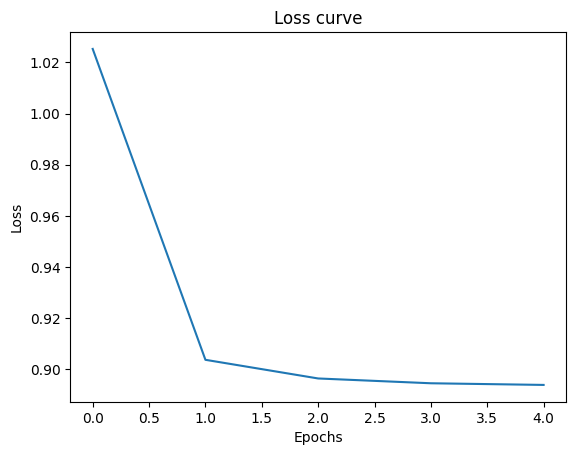

In [15]:
plot_loss(loss_values)

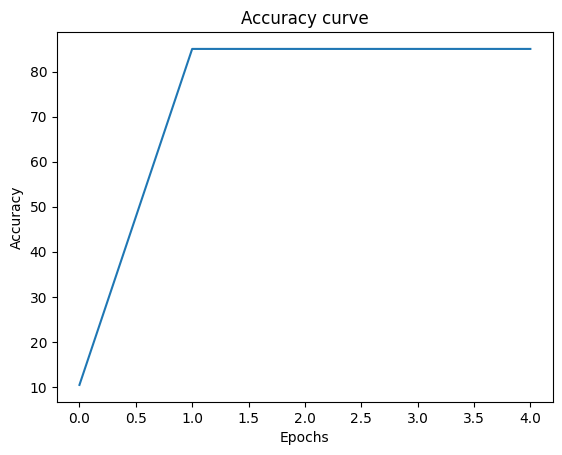

In [16]:
plot_accuracy(accuracy_values)

### Train model with undersampling

In [ ]:
net = Net()
net.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(),lr=0.002)

data_train, data_test, target_train, target_test = preprocessor.get_preprocessed_dataset_for_neural_network_undersampled()
print(target_train)

train_dataset = CustomBrfssDataset(data_train, target_train)
test_dataset = CustomBrfssDataset(data_test, target_test)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

loss_values, accuracy_values = train_network()